In [1]:
import h5py
import cv2
import torch
import warp_norm
import matplotlib
import sys
sys.path.append("./FaceAlignment")
import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from model import gaze_network
from torchvision import transforms
import pickle
import pandas as pd

with open('./gaze_pred.pkl', 'rb') as fo:
    tinydict = pickle.load(fo, encoding='bytes')

In [2]:
file_names = tinydict['file_name']
file_dict = []
for file_name in file_names:
    file_name = str(file_name).strip('()').split(',')
    for file in file_name:
        file_dict.append(int(file.strip("''").split('/')[6].split('.')[0][19:]))
        # print(file.strip("''").split('/')[6].split('.')[0][19:])
print(file_dict)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 22

In [3]:
with open('/home/hgh/hghData/Datasets/dataset_dict.pkl', 'rb') as fo:
    tinydict2 = pickle.load(fo, encoding='bytes')

In [4]:
ground_truth = [[],[],[],[],[],[],[],[]]
pred = [[],[],[],[],[],[],[],[]]
RMat = [[],[],[],[],[],[],[],[]]
for i in range(len(file_dict)):
    number = int((file_dict[i] - 1)/100)
    ground_truth[number].append(tinydict['label'][i])
    pred[number].append(tinydict['pred_gaze'][i])
    RMat[number].append(tinydict2[i]['R'])
for i in range(len(ground_truth)):
    ground_truth[i] = np.vstack(ground_truth[i])
    pred[i] = np.vstack(pred[i])
print(RMat[0][0])

[[ 0.99934383 -0.03606395  0.00336276]
 [ 0.03610734  0.99925146 -0.01388445]
 [-0.00285951  0.01399676  0.99989795]]


In [5]:
# 处理
print(RMat[0])

[array([[ 0.99934383, -0.03606395,  0.00336276],
       [ 0.03610734,  0.99925146, -0.01388445],
       [-0.00285951,  0.01399676,  0.99989795]]), array([[ 0.99973859, -0.02249691,  0.00407825],
       [ 0.02256111,  0.99961019, -0.0164456 ],
       [-0.00370668,  0.01653332,  0.99985644]]), array([[ 0.99983164, -0.01774629,  0.00466459],
       [ 0.01781641,  0.99972196, -0.01544613],
       [-0.00438918,  0.01552664,  0.99986982]]), array([[ 0.99965685, -0.02579486,  0.00456191],
       [ 0.02585625,  0.99956829, -0.0139534 ],
       [-0.00420001,  0.01406656,  0.99989224]]), array([[ 0.99983171, -0.01708909,  0.00667257],
       [ 0.01721608,  0.99966237, -0.01946139],
       [-0.00633774,  0.01957299,  0.99978834]]), array([[ 0.99985343, -0.01577098,  0.00666264],
       [ 0.01588798,  0.99971373, -0.01788933],
       [-0.0063786 ,  0.01799256,  0.99981777]]), array([[ 0.99980547, -0.01829084,  0.00738018],
       [ 0.01846575,  0.99953239, -0.02437266],
       [-0.00693093,  0.024

In [6]:
# 将pitchyaw转换成vector
for i in range(len(ground_truth)):
    pred[i] = warp_norm.pitchyaw_to_vector(pred[i])

print(pred[0][0])

epi = 0.7
org_pred.append(np.dot(np.linalg.inv(RMat[i]), pred[i].T))
# 将归一化向量还原
org_pred = [[],[],[],[],[],[],[],[]]
for i in range(len(ground_truth)):
    for j in range(len(RMat[i])):
        RMat[i][j][2] *= epi
        print(RMat[i][j])
        org_pred[i].append(np.dot(np.linalg.inv(RMat[i][j]), pred[i][j].T))
print(org_pred[0][0])

[-0.16203392 -0.14296676  0.97637366]
[[ 0.99934383 -0.03606395  0.00336276]
 [ 0.03610734  0.99925146 -0.01388445]
 [-0.00200166  0.00979773  0.69992857]]
[[ 0.99973859 -0.02249691  0.00407825]
 [ 0.02256111  0.99961019 -0.0164456 ]
 [-0.00259468  0.01157332  0.69989951]]
[[ 0.99983164 -0.01774629  0.00466459]
 [ 0.01781641  0.99972196 -0.01544613]
 [-0.00307243  0.01086865  0.69990887]]
[[ 0.99965685 -0.02579486  0.00456191]
 [ 0.02585625  0.99956829 -0.0139534 ]
 [-0.00294001  0.00984659  0.69992457]]
[[ 0.99983171 -0.01708909  0.00667257]
 [ 0.01721608  0.99966237 -0.01946139]
 [-0.00443642  0.01370109  0.69985184]]
[[ 0.99985343 -0.01577098  0.00666264]
 [ 0.01588798  0.99971373 -0.01788933]
 [-0.00446502  0.01259479  0.69987244]]
[[ 0.99980547 -0.01829084  0.00738018]
 [ 0.01846575  0.99953239 -0.02437266]
 [-0.00485165  0.01715294  0.69977299]]
[[ 0.99997291  0.00648562  0.00348082]
 [-0.00640674  0.99973275 -0.02221199]
 [-0.00253677  0.01553236  0.69982306]]
[[ 9.99821443e-01 

In [7]:
pixel_scale_tan = np.array([0.202, 0.224])
pixel_scale_chen = np.array([0.22, 0.235])

pred_gc = [[],[],[],[],[],[],[],[]]
for i in range(len(ground_truth)):
    for j in range(len(org_pred[i])):
        if i%2 == 0:
            pred_gc[i].append(warp_norm.vector_to_gc(org_pred[i][j], pixel_scale_tan))
        else:
            pred_gc[i].append(warp_norm.vector_to_gc(org_pred[i][j], pixel_scale_chen))
print(pred_gc[0])

[array([-363.97602202,  225.42083637]), array([-56.19714852, 318.15262416]), array([174.7892021 , 154.90206121]), array([375.583767  , 229.70659266]), array([231.55518937, 367.21606261]), array([298.51906648, 197.61954767]), array([333.91282972, 473.09981538]), array([161.82395837, 123.64788415]), array([-480.51601481,  242.92305159]), array([-488.4273723 ,  172.54115956]), array([-81.46665357, 108.39302298]), array([-384.00726872,  111.21881648]), array([-250.03938219,  232.21865439]), array([ 58.91419752, 202.02739709]), array([152.02042837, 152.62497153]), array([-239.12101058,  383.14969032]), array([ 94.79369257, 476.06165605]), array([334.06578219, 329.80026412]), array([ 16.28425166, 164.37699488]), array([151.13783154, 256.98017213]), array([  3.08369809, 144.80760271]), array([-424.32501871,   48.36268067]), array([292.93190556, 362.08645738]), array([ 42.32816683, 349.7011466 ]), array([179.28086681, 330.44830112]), array([-156.50338644,  370.71744368]), array([341.34678806, 

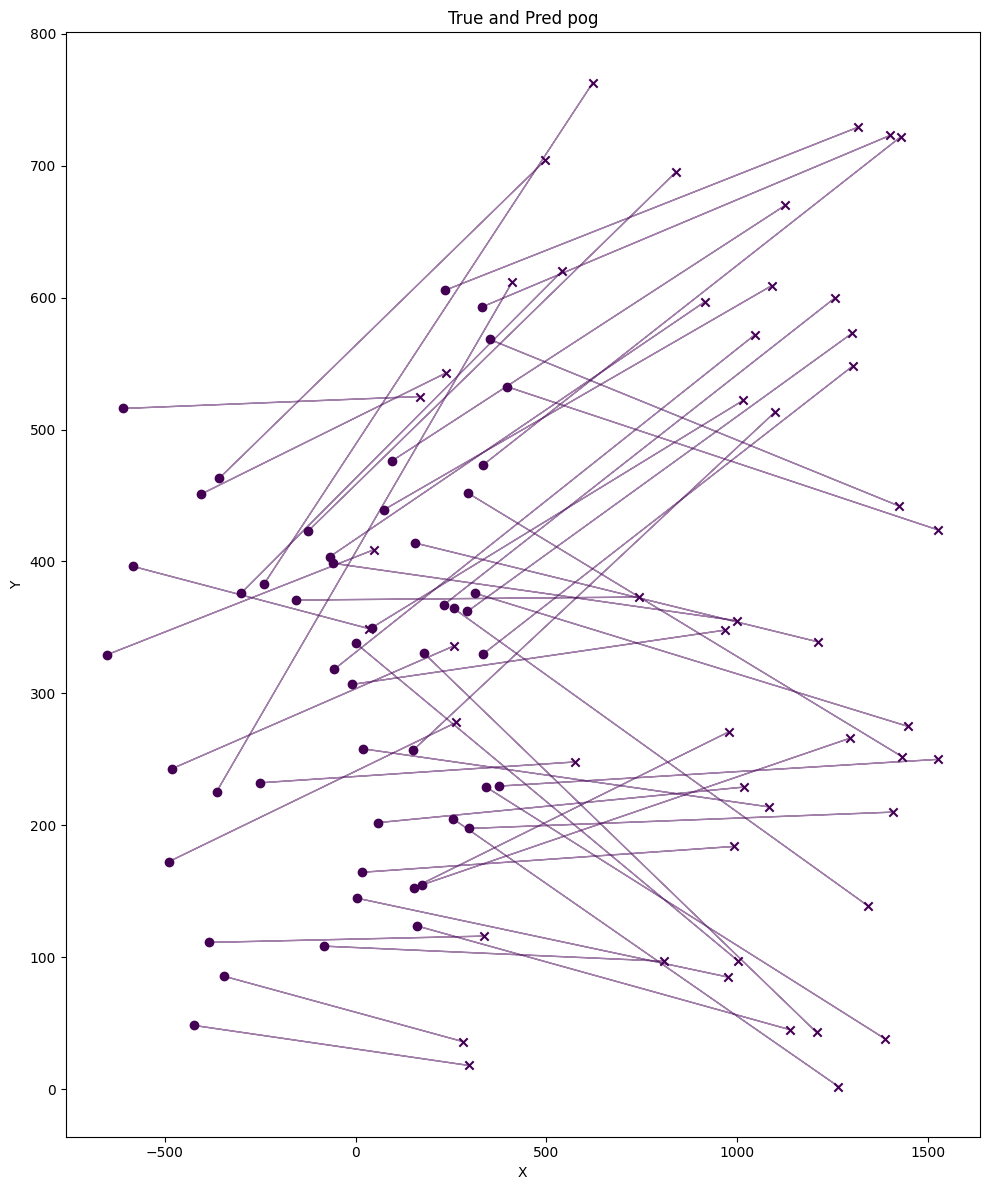

In [8]:
plt.figure(figsize=(10, 12))

colors = plt.cm.viridis(np.linspace(0, 1, 8))

i = 0
for j in range(len(pred[i])):
    if j < 50:
        plt.scatter(pred_gc[i][j][0], pred_gc[i][j][1], marker='o',color = colors[i], label=f'Measured')
        plt.scatter(ground_truth[i][j][0], ground_truth[i][j][1], marker='x',color = colors[i], label=f'True')
        plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], pred_gc[i][j][0] - ground_truth[i][j][0], pred_gc[i][j][1] - ground_truth[i][j][1], color=colors[i], alpha=0.5)

plt.title('True and Pred pog')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend()

plt.tight_layout()
plt.show()


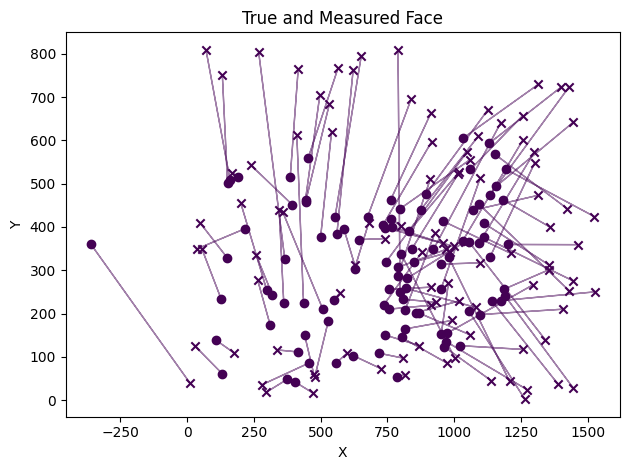

In [9]:
org_tan = np.array([800,0])
org_chen = np.array([650,0])
pred_gc_org = [[],[],[],[],[],[],[],[]]
for i in range(8):
    if i % 2 == 0:
        pred_gc_org[i] = org_tan + pred_gc[i]
    else:
        pred_gc_org[i] = org_chen + pred_gc[i]
i = 0
for j in range(len(pred[i])):
    plt.scatter(pred_gc_org[i][j][0], pred_gc_org[i][j][1], marker='o',color = colors[i], label=f'Measured')
    plt.scatter(ground_truth[i][j][0], ground_truth[i][j][1], marker='x',color = colors[i], label=f'True')
    plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], pred_gc_org[i][j][0] - ground_truth[i][j][0], pred_gc_org[i][j][1] - ground_truth[i][j][1], color=colors[i], alpha=0.5)

plt.title('True and Measured Face')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# calculate standard deviation distance
l2 = []
for i in range(8):
    l2.append(np.mean(np.linalg.norm(ground_truth[i]-pred_gc_org[i],axis = 1)))
print(l2)
print(np.mean(l2[:4]))

[232.69908959979287, 177.12827499559447, 298.94222597301007, 257.4244536660837, 413.3128517104203, 371.7719034936724, 522.2352896236614, 360.54565812629204]
241.5485110586203


In [11]:
def vModule(devSt, preds, pogs, w, h):
    blink = []
    eps = 3*devSt
    vpreds = []
    vpogs = []
    for pred,pog in zip(preds,pogs):
        print(pred, pog)
        # condition 1: in the screen
        if 0 <= pred[0] <= w and 0 <= pred[1] <= h:
            l2 = np.linalg.norm(pred - pog)
            print(l2)
            if l2 < eps:
                blink.append(1)
                vpreds.append(pred)
                vpogs.append(pog)
                continue
        blink.append(0)
    vpreds = np.asarray(vpreds)
    vpogs = np.asarray(vpogs)
    blink = np.asarray(blink)
    return blink,vpreds,vpogs
    

## 对每组数据作可靠性校验（不再需要）

In [12]:
blinks = []
for i in range(8):
    blinks.append([])
    if i%2 == 0:
        blink,_,_ = vModule(l2[i],pred_gc_org[i],ground_truth[i],1920,1080)
        blinks[i].append(blink)
    else:
        blink,_,_ = vModule(l2[i],pred_gc_org[i],ground_truth[i],1300,700)
        blinks[i].append(blink)

[436.02397798 225.42083637] [411. 612.]
387.3882409543096
[743.80285148 318.15262416] [1047.  572.]
395.43267580395013
[974.7892021  154.90206121] [1295.  266.]
338.93614013844416
[1175.583767    229.70659266] [1527.  250.]
352.00169203917255
[1031.55518937  367.21606261] [1257.  600.]
324.05821104709815
[1098.51906648  197.61954767] [1408.  210.]
309.7284678741489
[1133.91282972  473.09981538] [1429.  722.]
386.04111175400107
[961.82395837 123.64788415] [1139.   45.]
193.84746428291558
[319.48398519 242.92305159] [258. 336.]
111.55087969348081
[311.5726277  172.54115956] [264. 278.]
115.69235901278086
[718.53334643 108.39302298] [809.  97.]
91.18122822851666
[415.99273128 111.21881648] [336. 116.]
80.13549009508012
[549.96061781 232.21865439] [574. 248.]
28.75661254996663
[858.91419752 202.02739709] [1018.  229.]
161.35617080876094
[952.02042837 152.62497153] [979. 271.]
121.41064472027247
[560.87898942 383.14969032] [622. 763.]
384.73631970390795
[894.79369257 476.06165605] [1126.  6

In [13]:
print(blinks[2]) #从201开始的组

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]


In [14]:
# 这里gtr是认为所有的 ground truth都是可靠的
gtr = np.mean(ground_truth[0], axis=0)
print(gtr)

[863.43 375.45]


# 离线自校准

In [15]:
def scModule_offline(preds,history_pogs,history_preds):
    refine_pred = []
    tmp = np.mean(history_preds, axis=0)
    gtr = np.mean(history_pogs, axis=0)
    refine_pred = preds - (tmp - gtr)
    refine_pred = np.asarray(refine_pred)
    return refine_pred

In [16]:
# 此模块也不需要了
history_preds = []
for i in range(8):
    tmp = []
    for blink, pred in zip(blinks[i][0],pred_gc_org[i]):
        if blink == 1:
            tmp.append(pred)
    tmp = np.asarray(tmp)
    history_preds.append(tmp)

In [17]:
print(history_preds[0])

[[ 436.02397798  225.42083637]
 [ 743.80285148  318.15262416]
 [ 974.7892021   154.90206121]
 [1175.583767    229.70659266]
 [1031.55518937  367.21606261]
 [1098.51906648  197.61954767]
 [1133.91282972  473.09981538]
 [ 961.82395837  123.64788415]
 [ 319.48398519  242.92305159]
 [ 311.5726277   172.54115956]
 [ 718.53334643  108.39302298]
 [ 415.99273128  111.21881648]
 [ 549.96061781  232.21865439]
 [ 858.91419752  202.02739709]
 [ 952.02042837  152.62497153]
 [ 560.87898942  383.14969032]
 [ 894.79369257  476.06165605]
 [1134.06578219  329.80026412]
 [ 816.28425166  164.37699488]
 [ 951.13783154  256.98017213]
 [ 803.08369809  144.80760271]
 [ 375.67498129   48.36268067]
 [1092.93190556  362.08645738]
 [ 842.32816683  349.7011466 ]
 [ 979.28086681  330.44830112]
 [ 643.49661356  370.71744368]
 [1141.34678806  229.12562313]
 [ 820.42881108  257.92872887]
 [ 790.7315298   306.78522027]
 [ 443.5166523   463.18037338]
 [ 675.85701963  423.05583282]
 [ 956.66195613  413.93252464]
 [1057.1

## 单条件的误差校验

In [18]:
# 男生
refine_pred = []
pred_gc_org_all = np.vstack((pred_gc_org[0],pred_gc_org[2],pred_gc_org[4],pred_gc_org[6]))
gt_all = np.vstack((ground_truth[0],ground_truth[2],ground_truth[4],ground_truth[6]))
for i in range(4):
    i = i*2
    for j in range(4):
        j = j*2
        tmp = scModule_offline(pred_gc_org[j],history_preds=pred_gc_org[i], history_pogs=ground_truth[i])
        refine_pred.append(tmp)
        # 输出误差
        l2 = np.linalg.norm(tmp-ground_truth[j],axis = 1)
        print('history {}, pred {}, error {}'.format(i, j, np.mean(l2)))
    tmp = scModule_offline(pred_gc_org_all,history_preds=pred_gc_org[i], history_pogs=ground_truth[i])
    # 输出误差
    l2 = np.linalg.norm(tmp-gt_all,axis = 1)
    print('history {}, pred all, error {}'.format(i,np.mean(l2)))

history 0, pred 0, error 188.95905958050753
history 0, pred 2, error 348.1400694193259
history 0, pred 4, error 413.422040016595
history 0, pred 6, error 624.7261099387365
history 0, pred all, error 374.07172319089256
history 2, pred 0, error 375.0942024618201
history 2, pred 2, error 99.55535842875071
history 2, pred 4, error 424.23006438932225
history 2, pred 6, error 429.93798169059914
history 2, pred all, error 333.36197572002897
history 4, pred 0, error 238.92850966234732
history 4, pred 2, error 204.56715921466608
history 4, pred 4, error 385.6906936267944
history 4, pred 6, error 497.0637456740554
history 4, pred all, error 321.6089770556601
history 6, pred 0, error 563.7246822856458
history 6, pred 2, error 326.4609207728904
history 6, pred 4, error 554.1586034409089
history 6, pred 6, error 312.4259320806472
history 6, pred all, error 455.9697850386878


In [19]:
# 女生
refine_pred = []
pred_gc_org_all = np.vstack((pred_gc_org[1],pred_gc_org[3],pred_gc_org[5],pred_gc_org[7]))
gt_all = np.vstack((ground_truth[1],ground_truth[3],ground_truth[5],ground_truth[7]))
for i in range(4):
    i = i*2+1
    for j in range(4):
        j = j*2+1
        tmp = scModule_offline(pred_gc_org[j],history_preds=pred_gc_org[i], history_pogs=ground_truth[i])
        refine_pred.append(tmp)
        # 输出误差
        l2 = np.linalg.norm(tmp-ground_truth[j],axis = 1)
        print('history {}, pred {}, error {:.2f}'.format(i, j, np.mean(l2)))
    tmp = scModule_offline(pred_gc_org_all,history_preds=pred_gc_org[i], history_pogs=ground_truth[i])
    # 输出误差
    l2 = np.linalg.norm(tmp-gt_all,axis = 1)
    print('history {}, pred all, error {:.2f}'.format(i,np.mean(l2)))

history 1, pred 1, error 142.43
history 1, pred 3, error 340.30
history 1, pred 5, error 375.20
history 1, pred 7, error 388.76
history 1, pred all, error 300.38
history 3, pred 1, error 330.45
history 3, pred 3, error 161.12
history 3, pred 5, error 358.45
history 3, pred 7, error 399.41
history 3, pred all, error 298.51
history 5, pred 1, error 254.44
history 5, pred 3, error 230.92
history 5, pred 5, error 313.98
history 5, pred 7, error 437.10
history 5, pred all, error 291.33
history 7, pred 1, error 212.56
history 7, pred 3, error 295.82
history 7, pred 5, error 418.05
history 7, pred 7, error 345.44
history 7, pred all, error 312.06


## 可视化，训练数据来自第一组数据

In [20]:
# tmp_gt = np.vstack((ground_truth[4], ground_truth[2]))
# plt.scatter(refine_pred[:99,0],refine_pred[:99,1], marker='o', label=f'Measured')
# plt.scatter(tmp_gt[:99,0],tmp_gt[:99,1],marker='x', label=f'True')
# for j in range(99):
#     plt.arrow(tmp_gt[j,0], tmp_gt[j,1], refine_pred[j, 0] - tmp_gt[j, 0], refine_pred[j, 1] - tmp_gt[j, 1], alpha=0.5)

# #plt.title('True and Measured Face')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()

# plt.tight_layout()
# plt.show()

## 模块四PT

In [21]:
refine_pred = []
pred_gc_org_all = np.vstack((pred_gc_org[0],pred_gc_org[2],pred_gc_org[4],pred_gc_org[6]))
gt_all = np.vstack((ground_truth[1],ground_truth[3],ground_truth[5],ground_truth[7]))
i = 6
sc_all = scModule_offline(pred_gc_org_all,history_preds=pred_gc_org[i], history_pogs=ground_truth[i])

In [22]:
from st_refine_net import StRefine
state_path = './ckpt/spatical_transform_model_fake_eyetracking_dataset_1kg_128_72_error00_valid_random_ii_in_sequence_person_gt_lr_0.1_99_full.pt'
st_refine_net = StRefine(StNet_path=state_path)
# PoG_cm_history = [pi_star for pi_star, bi in zip(memory_pi_star, memory_bi) if bi > 0.5] # select valid pi_stars for history heatmap
refine_px = []
for i in range(sc_all.shape[0]):
    PoG_px_refined, is_refined, input_combmap, output_combmap = st_refine_net.refine(torch.from_numpy(sc_all[i]), torch.from_numpy(pred_gc_org[6]), return_full=True)
    refine_px.append(PoG_px_refined.detach().cpu().numpy())
refine_px = np.asarray(refine_px)

StRefine loaded from ./ckpt/spatical_transform_model_fake_eyetracking_dataset_1kg_128_72_error00_valid_random_ii_in_sequence_person_gt_lr_0.1_99_full.pt ---jfejoij st_refine_net.py


/home/hgh/anaconda3/envs/gazeE/lib/python3.8/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/hgh/anaconda3/envs/gazeE/lib/python3.8/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


StRefine loaded from ./ckpt/spatical_transform_model_fake_eyetracking_dataset_1kg_128_72_error00_valid_random_ii_in_sequence_person_gt_lr_0.1_99_full.pt ---jfejoij st_refine_net.py


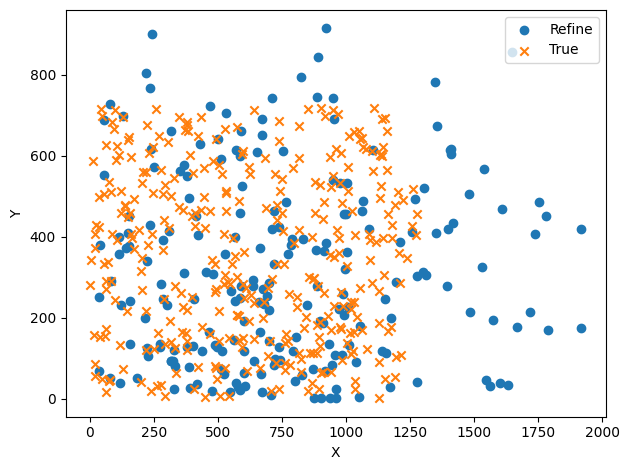

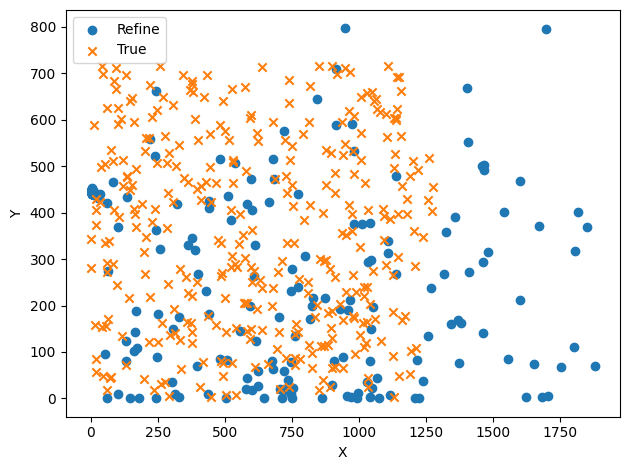

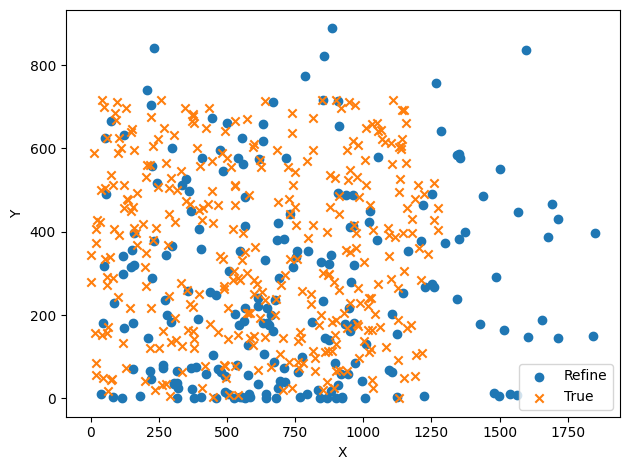

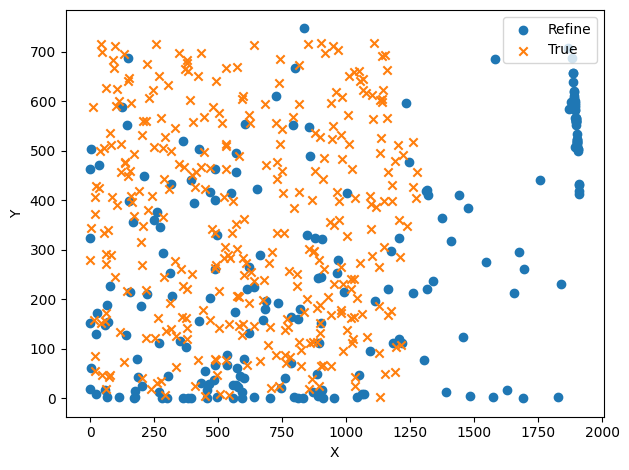

In [23]:
from st_refine_net import StRefine
state_path = './ckpt/spatical_transform_model_fake_eyetracking_dataset_1kg_128_72_error00_valid_random_ii_in_sequence_person_gt_lr_0.1_99_full.pt'
st_refine_net = StRefine(StNet_path=state_path)
scale_factor_x = 1920 / 1500
scale_factor_y = 1080 / 800
gt_all_scale = gt_all * np.array([scale_factor_x, scale_factor_y])
# PoG_cm_history = [pi_star for pi_star, bi in zip(memory_pi_star, memory_bi) if bi > 0.5] # select valid pi_stars for history heatmap
for j in range(4):
    refine_px = []
    for i in range(sc_all.shape[0]):
        PoG_px_refined, is_refined, input_combmap, output_combmap = st_refine_net.refine(torch.from_numpy(sc_all[i]), torch.from_numpy(pred_gc_org[j*2]), return_full=True)
        refine_px.append(PoG_px_refined.detach().cpu().numpy())
    refine_px = np.asarray(refine_px)

    min_value = 0
    max_x_value = 1920
    max_y_value = 1080

    mask = np.logical_and(np.logical_and(min_value < refine_px[:, 0], refine_px[:, 0] < max_x_value),
                        np.logical_and(min_value < refine_px[:, 1], refine_px[:, 1] < max_y_value))
    # pred_filtered_points = refine_px[mask]
    # gt_filtered_points = gt_all[mask]
    pred_filtered_points = refine_px[mask]
    gt_filtered_points = gt_all
    plt.scatter(pred_filtered_points[:,0],pred_filtered_points[:,1], marker='o', label=f'Refine')
    plt.scatter(gt_filtered_points[:,0],gt_filtered_points[:,1],marker='x', label=f'True')
    #for j in range(gt_all.shape[0]):
    #    plt.arrow(tmp_gt[j,0], tmp_gt[j,1], refine_pred[j, 0] - tmp_gt[j, 0], refine_pred[j, 1] - tmp_gt[j, 1], alpha=0.5)

    # l2 = np.linalg.norm(pred_filtered_points-gt_filtered_points,axis = 1)
    # plt.title('history {}, error {:.2f}'.format(j*2, np.mean(l2)))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [24]:
l2 = np.linalg.norm(sc_all-gt_all_scale,axis = 1)
print('history {}, pred all, error {}'.format(-1,np.mean(l2)))

ValueError: operands could not be broadcast together with shapes (350,2) (339,2) 

# 一个小测试

In [ ]:
import matplotlib.pyplot as plt

# 读取txt文件
file_path = './coordinate_test.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

tan = []
chen = []
# 提取符合条件的行的坐标信息并绘制图形
for line in lines:
    # 分割每一行的数据
    data = line.strip().split(',')
    x = int(data[-2])
    y = int(data[-1])
    # 检查第二列是否为'tan'
    if data[1].lower() == 'tan':
        # 提取最后两位坐标信息
        tan.append([x,y])
        # 绘制点
    else:
        chen.append([x,y])
tan = np.asarray(tan).reshape((-1,2))
chen = np.asarray(chen).reshape((-1,2))

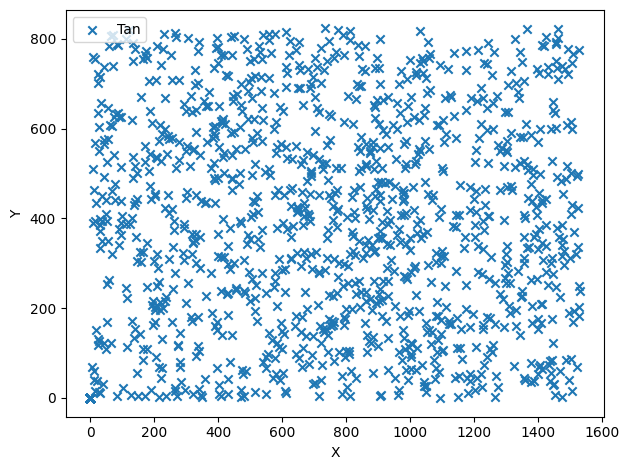

In [ ]:
plt.scatter(tan[:,0],tan[:,1],marker='x', label=f'Tan')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.tight_layout()
plt.show()

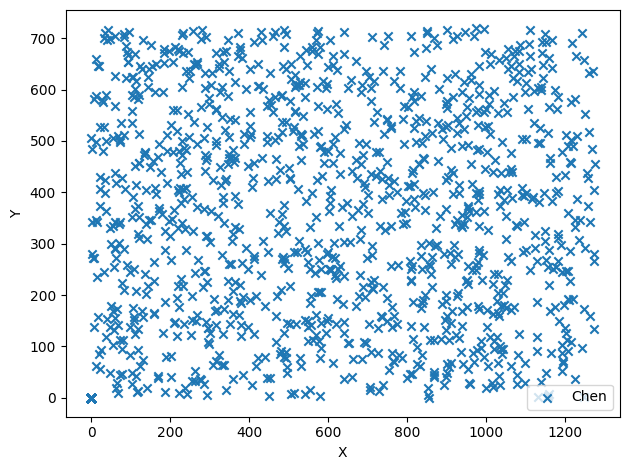

In [ ]:
plt.scatter(chen[:,0],chen[:,1],marker='x', label=f'Chen')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.tight_layout()
plt.show()